# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


## Run Object Detection

Processing 1 images
image                    shape: (2992, 5152, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 5152.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


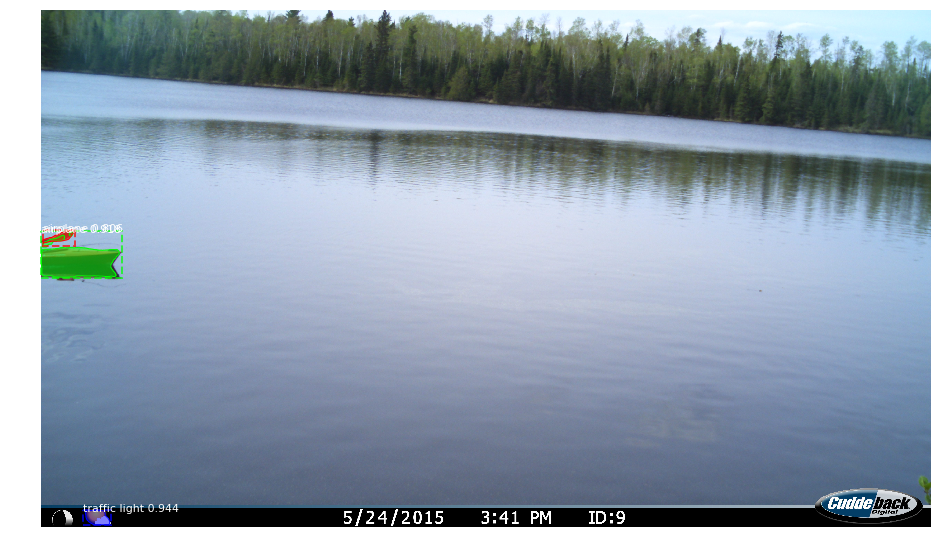

In [14]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('/Users/aaron/Desktop/LeoEast/LeoEast0245.JPG')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Count features and add to pandas dataframe

In [13]:
import pandas as pd
import glob, time

jpgs = sorted(glob.glob(os.path.join('/Users/aaron/Desktop/LeoEast', '*.JPG')))

counter = 1
data = []
for jpg in jpgs:
    start = time.time()
    image = skimage.io.imread(jpg)
    
    # Run detection
    results = model.detect([image], verbose=0) # switch to verbose = 1 for image info
    
    # Count features
    vals = [item for item in list(results[0].get('class_ids')) if str(item) in ['1','9']]
    print('There are {0} watercraft and {1} boat anglers'.format(vals.count(9), vals.count(1)))

    # Visualize results
    #r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #                            class_names, r['scores'])
    
    # Add results to pandas dataframe
    data.append({'image_path':os.path.basename(jpg), 'watercraft':vals.count(9), 'boat_anglers':vals.count(1)})
    
    # Keep a verbose tally on where we are at on the processing
    end = time.time()
    print('{0}: {1} of {2} processed in {3} seconds'.format(os.path.basename(jpg), counter, len(jpgs), round(end - start, 2)))
    counter += 1
    
df = pd.DataFrame(data, columns = ['image_path', 'watercraft', 'boat_anglers'])
df
print("Processing complete")


There are 0 watercraft and 0 boat anglers
LeoEast0001.JPG: 1 of 2516 processed in 12.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0002.JPG: 2 of 2516 processed in 12.48 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0003.JPG: 3 of 2516 processed in 13.75 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0004.JPG: 4 of 2516 processed in 13.49 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0005.JPG: 5 of 2516 processed in 13.55 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0006.JPG: 6 of 2516 processed in 13.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0007.JPG: 7 of 2516 processed in 12.89 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0008.JPG: 8 of 2516 processed in 12.9 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0009.JPG: 9 of 2516 processed in 12.88 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0010.JPG: 10 of 2516 processed in 12.93 seconds
There are 0 watercraft and 0 boat angler

There are 1 watercraft and 1 boat anglers
LeoEast0086.JPG: 86 of 2516 processed in 12.88 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0087.JPG: 87 of 2516 processed in 12.86 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0088.JPG: 88 of 2516 processed in 12.49 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0089.JPG: 89 of 2516 processed in 12.06 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0090.JPG: 90 of 2516 processed in 12.36 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0091.JPG: 91 of 2516 processed in 12.27 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0092.JPG: 92 of 2516 processed in 12.38 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0093.JPG: 93 of 2516 processed in 12.51 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0094.JPG: 94 of 2516 processed in 12.37 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0095.JPG: 95 of 2516 processed in 14.64 seconds
There are 0 watercraft and 0 b

There are 0 watercraft and 0 boat anglers
LeoEast0170.JPG: 170 of 2516 processed in 12.34 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0171.JPG: 171 of 2516 processed in 13.09 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0172.JPG: 172 of 2516 processed in 12.27 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0173.JPG: 173 of 2516 processed in 14.2 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0174.JPG: 174 of 2516 processed in 12.83 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0175.JPG: 175 of 2516 processed in 12.75 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0176.JPG: 176 of 2516 processed in 12.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0177.JPG: 177 of 2516 processed in 12.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0178.JPG: 178 of 2516 processed in 13.31 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0179.JPG: 179 of 2516 processed in 11.95 seconds
There are 0 watercraft 

There are 0 watercraft and 0 boat anglers
LeoEast0254.JPG: 254 of 2516 processed in 12.55 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0255.JPG: 255 of 2516 processed in 12.2 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0256.JPG: 256 of 2516 processed in 13.14 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0257.JPG: 257 of 2516 processed in 13.1 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0258.JPG: 258 of 2516 processed in 13.19 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0259.JPG: 259 of 2516 processed in 13.17 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0260.JPG: 260 of 2516 processed in 12.89 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0261.JPG: 261 of 2516 processed in 12.12 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0262.JPG: 262 of 2516 processed in 12.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0263.JPG: 263 of 2516 processed in 12.66 seconds
There are 0 watercraft

There are 0 watercraft and 0 boat anglers
LeoEast0338.JPG: 338 of 2516 processed in 11.93 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0339.JPG: 339 of 2516 processed in 11.84 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0340.JPG: 340 of 2516 processed in 11.86 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0341.JPG: 341 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0342.JPG: 342 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0343.JPG: 343 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0344.JPG: 344 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0345.JPG: 345 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0346.JPG: 346 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0347.JPG: 347 of 2516 processed in 11.65 seconds
There are 0 watercraf

There are 0 watercraft and 0 boat anglers
LeoEast0422.JPG: 422 of 2516 processed in 13.51 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0423.JPG: 423 of 2516 processed in 13.78 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0424.JPG: 424 of 2516 processed in 13.46 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0425.JPG: 425 of 2516 processed in 16.32 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0426.JPG: 426 of 2516 processed in 13.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0427.JPG: 427 of 2516 processed in 13.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0428.JPG: 428 of 2516 processed in 12.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0429.JPG: 429 of 2516 processed in 12.04 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0430.JPG: 430 of 2516 processed in 11.82 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0431.JPG: 431 of 2516 processed in 11.61 seconds
There are 0 watercraft

There are 0 watercraft and 0 boat anglers
LeoEast0506.JPG: 506 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0507.JPG: 507 of 2516 processed in 11.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0508.JPG: 508 of 2516 processed in 11.77 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0509.JPG: 509 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0510.JPG: 510 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0511.JPG: 511 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0512.JPG: 512 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0513.JPG: 513 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0514.JPG: 514 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0515.JPG: 515 of 2516 processed in 11.7 seconds
There are 0 watercraft

There are 0 watercraft and 0 boat anglers
LeoEast0590.JPG: 590 of 2516 processed in 11.9 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0591.JPG: 591 of 2516 processed in 11.56 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0592.JPG: 592 of 2516 processed in 11.56 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0593.JPG: 593 of 2516 processed in 11.48 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0594.JPG: 594 of 2516 processed in 11.56 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0595.JPG: 595 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0596.JPG: 596 of 2516 processed in 11.57 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0597.JPG: 597 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0598.JPG: 598 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0599.JPG: 599 of 2516 processed in 11.55 seconds
There are 0 watercraft

There are 0 watercraft and 0 boat anglers
LeoEast0674.JPG: 674 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0675.JPG: 675 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0676.JPG: 676 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0677.JPG: 677 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0678.JPG: 678 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0679.JPG: 679 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0680.JPG: 680 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0681.JPG: 681 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0682.JPG: 682 of 2516 processed in 11.98 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0683.JPG: 683 of 2516 processed in 11.73 seconds
There are 0 watercra

There are 0 watercraft and 0 boat anglers
LeoEast0758.JPG: 758 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0759.JPG: 759 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0760.JPG: 760 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0761.JPG: 761 of 2516 processed in 11.75 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0762.JPG: 762 of 2516 processed in 11.78 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0763.JPG: 763 of 2516 processed in 11.77 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0764.JPG: 764 of 2516 processed in 11.83 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0765.JPG: 765 of 2516 processed in 11.97 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0766.JPG: 766 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0767.JPG: 767 of 2516 processed in 11.8 seconds
There are 1 watercraf

There are 0 watercraft and 0 boat anglers
LeoEast0842.JPG: 842 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0843.JPG: 843 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0844.JPG: 844 of 2516 processed in 11.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0845.JPG: 845 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0846.JPG: 846 of 2516 processed in 11.79 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0847.JPG: 847 of 2516 processed in 11.92 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0848.JPG: 848 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0849.JPG: 849 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0850.JPG: 850 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0851.JPG: 851 of 2516 processed in 11.68 seconds
There are 0 watercraf

There are 0 watercraft and 0 boat anglers
LeoEast0926.JPG: 926 of 2516 processed in 11.74 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0927.JPG: 927 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0928.JPG: 928 of 2516 processed in 11.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0929.JPG: 929 of 2516 processed in 11.95 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0930.JPG: 930 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0931.JPG: 931 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0932.JPG: 932 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0933.JPG: 933 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0934.JPG: 934 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast0935.JPG: 935 of 2516 processed in 11.68 seconds
There are 0 watercraft

There are 0 watercraft and 0 boat anglers
LeoEast1010.JPG: 1010 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1011.JPG: 1011 of 2516 processed in 11.93 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1012.JPG: 1012 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1013.JPG: 1013 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1014.JPG: 1014 of 2516 processed in 11.6 seconds
There are 3 watercraft and 2 boat anglers
LeoEast1015.JPG: 1015 of 2516 processed in 11.74 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1016.JPG: 1016 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1017.JPG: 1017 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1018.JPG: 1018 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1019.JPG: 1019 of 2516 processed in 11.71 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast1093.JPG: 1093 of 2516 processed in 11.86 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1094.JPG: 1094 of 2516 processed in 11.57 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1095.JPG: 1095 of 2516 processed in 11.47 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1096.JPG: 1096 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1097.JPG: 1097 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1098.JPG: 1098 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1099.JPG: 1099 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1100.JPG: 1100 of 2516 processed in 11.79 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1101.JPG: 1101 of 2516 processed in 11.81 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1102.JPG: 1102 of 2516 processed in 11.64 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1176.JPG: 1176 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1177.JPG: 1177 of 2516 processed in 11.41 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1178.JPG: 1178 of 2516 processed in 11.79 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1179.JPG: 1179 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1180.JPG: 1180 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1181.JPG: 1181 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1182.JPG: 1182 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1183.JPG: 1183 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1184.JPG: 1184 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1185.JPG: 1185 of 2516 processed in 11.84 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1259.JPG: 1259 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1260.JPG: 1260 of 2516 processed in 11.55 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1261.JPG: 1261 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1262.JPG: 1262 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1263.JPG: 1263 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1264.JPG: 1264 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1265.JPG: 1265 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1266.JPG: 1266 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1267.JPG: 1267 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1268.JPG: 1268 of 2516 processed in 11.6 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast1342.JPG: 1342 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1343.JPG: 1343 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1344.JPG: 1344 of 2516 processed in 11.51 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1345.JPG: 1345 of 2516 processed in 11.56 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1346.JPG: 1346 of 2516 processed in 11.52 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1347.JPG: 1347 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1348.JPG: 1348 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1349.JPG: 1349 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1350.JPG: 1350 of 2516 processed in 11.83 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1351.JPG: 1351 of 2516 processed in 11.74 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1425.JPG: 1425 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1426.JPG: 1426 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1427.JPG: 1427 of 2516 processed in 11.67 seconds
There are 0 watercraft and 1 boat anglers
LeoEast1428.JPG: 1428 of 2516 processed in 11.61 seconds
There are 0 watercraft and 1 boat anglers
LeoEast1429.JPG: 1429 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1430.JPG: 1430 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1431.JPG: 1431 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1432.JPG: 1432 of 2516 processed in 12.11 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1433.JPG: 1433 of 2516 processed in 11.68 seconds
There are 1 watercraft and 0 boat anglers
LeoEast1434.JPG: 1434 of 2516 processed in 11.78 seconds
There are 0 

There are 0 watercraft and 0 boat anglers
LeoEast1508.JPG: 1508 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1509.JPG: 1509 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1510.JPG: 1510 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1511.JPG: 1511 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1512.JPG: 1512 of 2516 processed in 11.74 seconds
There are 1 watercraft and 0 boat anglers
LeoEast1513.JPG: 1513 of 2516 processed in 11.39 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1514.JPG: 1514 of 2516 processed in 12.06 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1515.JPG: 1515 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1516.JPG: 1516 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1517.JPG: 1517 of 2516 processed in 11.86 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1591.JPG: 1591 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1592.JPG: 1592 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1593.JPG: 1593 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1594.JPG: 1594 of 2516 processed in 11.67 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1595.JPG: 1595 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1596.JPG: 1596 of 2516 processed in 11.76 seconds
There are 1 watercraft and 0 boat anglers
LeoEast1597.JPG: 1597 of 2516 processed in 11.73 seconds
There are 1 watercraft and 0 boat anglers
LeoEast1598.JPG: 1598 of 2516 processed in 11.68 seconds
There are 1 watercraft and 0 boat anglers
LeoEast1599.JPG: 1599 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1600.JPG: 1600 of 2516 processed in 11.64 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1674.JPG: 1674 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1675.JPG: 1675 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1676.JPG: 1676 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1677.JPG: 1677 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1678.JPG: 1678 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1679.JPG: 1679 of 2516 processed in 12.05 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1680.JPG: 1680 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1681.JPG: 1681 of 2516 processed in 11.71 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1682.JPG: 1682 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1683.JPG: 1683 of 2516 processed in 11.68 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast1757.JPG: 1757 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1758.JPG: 1758 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1759.JPG: 1759 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1760.JPG: 1760 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1761.JPG: 1761 of 2516 processed in 12.07 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1762.JPG: 1762 of 2516 processed in 11.51 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1763.JPG: 1763 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1764.JPG: 1764 of 2516 processed in 11.63 seconds
There are 1 watercraft and 2 boat anglers
LeoEast1765.JPG: 1765 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1766.JPG: 1766 of 2516 processed in 11.51 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast1840.JPG: 1840 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1841.JPG: 1841 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1842.JPG: 1842 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1843.JPG: 1843 of 2516 processed in 12.05 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1844.JPG: 1844 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1845.JPG: 1845 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1846.JPG: 1846 of 2516 processed in 11.49 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1847.JPG: 1847 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1848.JPG: 1848 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1849.JPG: 1849 of 2516 processed in 11.59 seconds
There are 0 

There are 0 watercraft and 0 boat anglers
LeoEast1923.JPG: 1923 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1924.JPG: 1924 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1925.JPG: 1925 of 2516 processed in 11.83 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1926.JPG: 1926 of 2516 processed in 11.86 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1927.JPG: 1927 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1928.JPG: 1928 of 2516 processed in 11.69 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1929.JPG: 1929 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1930.JPG: 1930 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1931.JPG: 1931 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast1932.JPG: 1932 of 2516 processed in 11.59 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast2006.JPG: 2006 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2007.JPG: 2007 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2008.JPG: 2008 of 2516 processed in 11.82 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2009.JPG: 2009 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2010.JPG: 2010 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2011.JPG: 2011 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2012.JPG: 2012 of 2516 processed in 11.57 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2013.JPG: 2013 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2014.JPG: 2014 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2015.JPG: 2015 of 2516 processed in 11.68 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast2089.JPG: 2089 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2090.JPG: 2090 of 2516 processed in 12.13 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2091.JPG: 2091 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2092.JPG: 2092 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2093.JPG: 2093 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2094.JPG: 2094 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2095.JPG: 2095 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2096.JPG: 2096 of 2516 processed in 11.6 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2097.JPG: 2097 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2098.JPG: 2098 of 2516 processed in 11.67 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast2172.JPG: 2172 of 2516 processed in 11.71 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2173.JPG: 2173 of 2516 processed in 12.11 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2174.JPG: 2174 of 2516 processed in 11.8 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2175.JPG: 2175 of 2516 processed in 11.82 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2176.JPG: 2176 of 2516 processed in 11.55 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2177.JPG: 2177 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2178.JPG: 2178 of 2516 processed in 11.74 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2179.JPG: 2179 of 2516 processed in 11.77 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2180.JPG: 2180 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2181.JPG: 2181 of 2516 processed in 11.52 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast2255.JPG: 2255 of 2516 processed in 12.0 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2256.JPG: 2256 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2257.JPG: 2257 of 2516 processed in 11.48 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2258.JPG: 2258 of 2516 processed in 11.75 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2259.JPG: 2259 of 2516 processed in 11.58 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2260.JPG: 2260 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2261.JPG: 2261 of 2516 processed in 11.65 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2262.JPG: 2262 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2263.JPG: 2263 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2264.JPG: 2264 of 2516 processed in 11.66 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast2338.JPG: 2338 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2339.JPG: 2339 of 2516 processed in 11.45 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2340.JPG: 2340 of 2516 processed in 11.53 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2341.JPG: 2341 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2342.JPG: 2342 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2343.JPG: 2343 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2344.JPG: 2344 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2345.JPG: 2345 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2346.JPG: 2346 of 2516 processed in 11.63 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2347.JPG: 2347 of 2516 processed in 11.96 seconds
There are 

There are 0 watercraft and 0 boat anglers
LeoEast2421.JPG: 2421 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2422.JPG: 2422 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2423.JPG: 2423 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2424.JPG: 2424 of 2516 processed in 11.59 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2425.JPG: 2425 of 2516 processed in 11.62 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2426.JPG: 2426 of 2516 processed in 11.61 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2427.JPG: 2427 of 2516 processed in 11.71 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2428.JPG: 2428 of 2516 processed in 11.66 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2429.JPG: 2429 of 2516 processed in 11.86 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2430.JPG: 2430 of 2516 processed in 11.74 seconds
There are 0

There are 0 watercraft and 0 boat anglers
LeoEast2504.JPG: 2504 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2505.JPG: 2505 of 2516 processed in 11.74 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2506.JPG: 2506 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2507.JPG: 2507 of 2516 processed in 11.72 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2508.JPG: 2508 of 2516 processed in 11.75 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2509.JPG: 2509 of 2516 processed in 11.68 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2510.JPG: 2510 of 2516 processed in 11.73 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2511.JPG: 2511 of 2516 processed in 11.64 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2512.JPG: 2512 of 2516 processed in 11.7 seconds
There are 0 watercraft and 0 boat anglers
LeoEast2513.JPG: 2513 of 2516 processed in 11.68 seconds
There are 0 

## Assess the accuracy




In [32]:
from sklearn.metrics import mean_squared_error

# Write df to csv for safe keeping
#df.to_csv('/Users/aaron/gdrive/projects/fisheries_census_project/data/outdata/1st_run.csv')

# Read Matt's csv 
df2 = pd.read_csv('/Users/aaron/gdrive/projects/fisheries_census_project/data/indata/LeoEast.csv')

# Concatenate dfs
result = pd.concat([df, df2], axis =1)

# Calculate MSE
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
mse = mean_squared_error(result.Watercraft, result.watercraft)



In [33]:
mse



0.060810810810810814